In [3]:
#####################
#     LOAD DATA     #
#####################

import json_lines
import csv

def process_tweet(tweet):  
    d = {}
    d['hashtags'] = [hashtag['text'] for hashtag in tweet['entities']['hashtags']]
    d['text'] = tweet['full_text']
    d['user'] = tweet['user']['screen_name']
    d['user_loc'] = tweet['user']['location']
    d['created_at'] = tweet['created_at']
    return d

if False:
    with open('congress_dataset/senators-1.jsonl', 'rb') as f:
        with open(r'senators-1-tweets.csv', 'a') as file:
            writer = csv.writer(file)
            for item in json_lines.reader(f):
                # Only collect tweets in English
                if item['lang'] == 'en' and len(item['entities']['hashtags']) > 0:
                    tweet_data = process_tweet(item)
                    writer.writerow(list(tweet_data.values()))

                    
import pandas as pd
tweets = pd.read_csv("senators-1-tweets.csv", header=None, names=['hashtags', 'text', 'user', 'user_location', 'created_at'])  
print('num tweets: {}'.format(len(tweets)))


import spacy
nlp = spacy.load('en_core_web_md')

import random

docs = []
N = 100
rand_tweets = random.sample(range(len(tweets)), k=N)
for i, tw in enumerate(rand_tweets):
    if i % 1000 == 0:
        print('{}%'.format(100./N*i), end=' ')
    docs.append(nlp(tweets.iloc[i]['text']))
    
stop_words = ['senator', '\'s', '-PRON-', '’', '’s', 'amp', 'i' ]


# Clean tweets here
cleaned_tweets = []
cleaned_tweets_text = []
for doc in docs:
    curr_tweet = []
    for w in doc:
        if w.text == '\n' or w.is_stop or w.is_punct or w.like_num or w.like_url: continue
        if w.is_space or w.is_oov or not w.is_ascii or w.text.lower() in stop_words: continue
        curr_tweet.append(w.text.lower()) # add lemmatized version of the word
    if curr_tweet:
        cleaned_tweets.append(curr_tweet)
        cleaned_tweets_text.append(' '.join(curr_tweet))
        
        
# here we should get only cleaned tweets
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

bigram = gensim.models.Phrases(cleaned_tweets)
cleaned_tweets = [bigram[t] for t in cleaned_tweets]

# create dictionary and corpus
dictionary = Dictionary(cleaned_tweets)

# corpus = (token_id, count_in_curr_doc) , sparse representation
corpus = [dictionary.doc2bow(clean_tween) for clean_tween in cleaned_tweets]

num tweets: 449334
0.0% 

In [20]:
cleaned_tweets_id = [dictionary.doc2idx(document=tw) for tw in cleaned_tweets]

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [phi, theta]
>CategoricalGibbsMetropolis: [z]
100%|██████████| 2500/2500 [18:48<00:00,  2.25it/s] 
The acceptance probability does not match the target. It is 0.6907499965056502, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


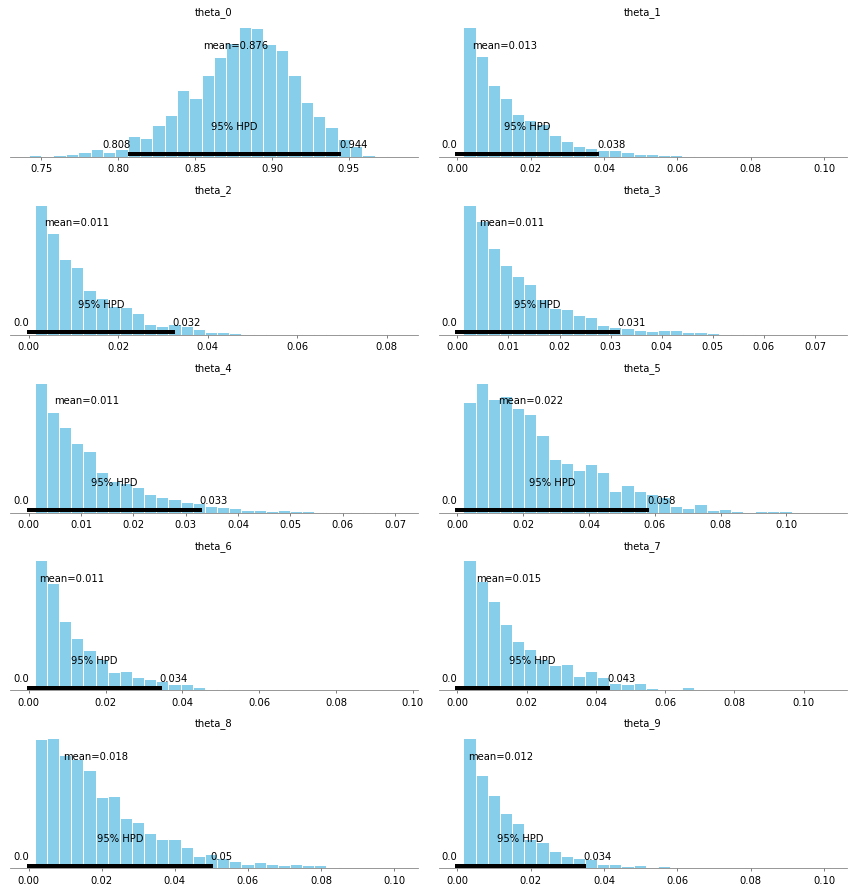

In [24]:
##### pymc3
import pymc3 as pm
import numpy as np

class NaiveLDA:
    def __init__(self, K, V, docs):
        self.K = K
        self.V = V
        self.D = len(docs)
        self.docs = docs
        self.model = None
        
    def init(self):
        # hyper for global distr. of topics
        alpha = np.ones(self.K)

        # hyper for distribution of words in topic
        beta = np.ones(self.V)
        
        with pm.Model() as model:
            # distribution over topics
            theta = pm.Dirichlet('theta', a=alpha)
            
            # distribution over words in topics
            phi = pm.Dirichlet('phi', a=beta, shape=(self.K, self.V))
            
            # topic of document
            z = pm.Categorical('z', p=theta, shape=(self.D,))
            
            # per document
            for i in range(self.D):
                # words in document
                w = pm.Categorical('w_{}'.format(i), p=phi[z[i]], observed=self.docs[i])

                
        self.model = model
        
V = len(dictionary)
K = 10
naive_lda = NaiveLDA(K, V, cleaned_tweets_id)
naive_lda.init()

with naive_lda.model:
    trace = pm.sample(2000, chains=1)
    pm.plot_posterior(trace, varnames=['theta']);

ValueError: num must be 1 <= num <= 3, not 4

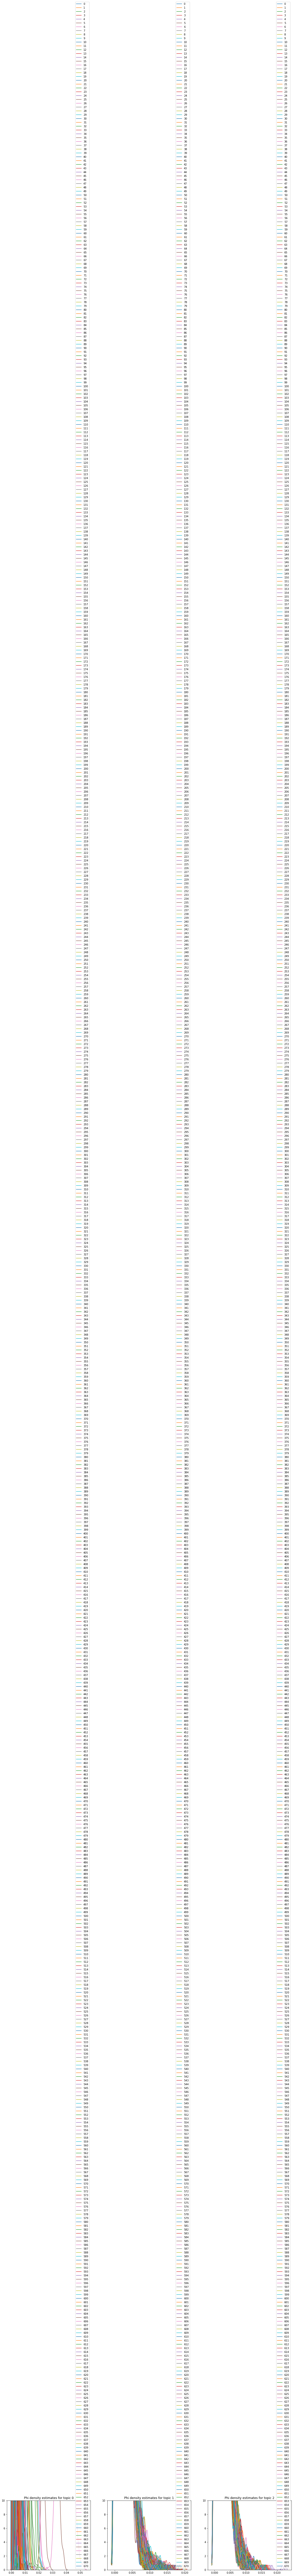

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phi_estimates(trace):
    plt.figure(figsize=(20,5))
    for i in range(K):
        plt.subplot(1, 3, i+1)
        for j in range(V):
            sns.distplot(trace['phi'][:, i, j], kde=True, hist=False, label=dictionary[j])
            plt.ylim([0, 10])
        plt.title(f'Phi density estimates for topic {i}')
        plt.legend(dictionary)
        
plot_phi_estimates(trace)

'after'